In [120]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import load_data_template
from src.features.games import GameFeatures

In [122]:
game_feat = GameFeatures(default_lags=3)
data = load_data_template()
data = game_feat.per_team_wrapper(data, game_feat.games_won_in_season, fillna=0)
data = game_feat.per_team_wrapper(data, game_feat.games_won_in_tourney, fillna=0)
data = game_feat.per_team_wrapper(data, game_feat.games_won_in_season_against_opponent, fillna=0, per_game=True)
data = game_feat.per_team_wrapper(data, game_feat.games_won_in_tourney_against_opponent, fillna=0, per_game=True)
data = game_feat.per_team_wrapper(data, game_feat.average_ranking_team, fillna=0, per_game=False)
data = game_feat.per_team_wrapper(data, game_feat.sd_ranking_team, fillna=0, per_game=False)
data.dropna(inplace=True)
data.sample()

,Season,team_a,team_b,in_target,game_set,a_win,DayNum,games_won_in_season_team_a,games_won_in_season_team_a_lag-1,games_won_in_season_team_a_lag-2,...,average_ranking_team_b_lag-2,average_ranking_team_b_lag-3,sd_rankings_team_a,sd_rankings_team_a_lag-1,sd_rankings_team_a_lag-2,sd_rankings_team_a_lag-3,sd_rankings_team_b,sd_rankings_team_b_lag-1,sd_rankings_team_b_lag-2,sd_rankings_team_b_lag-3
6526,2016,1371,1438,True,0,NaN,0.0,25,16.0,17.0,...,25.691686,57.907862,21.345331,24.852791,26.821789,28.488534,6.112293,2.480551,17.522593,24.959256


In [124]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss


X = data.drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target', 'DayNum'], axis=1)
y = data[['a_win']].astype(int)

kf = KFold(n_splits=15, shuffle=True)
metrics = []
for tr_i, t_i in kf.split(X):
    X_tr, y_tr = X.iloc[tr_i], y.iloc[tr_i]
    X_t, y_t = X.iloc[t_i], y.iloc[t_i]
    xgb = XGBClassifier()
    xgb.fit(X_tr.values, y_tr.values.reshape(-1))
    preds = xgb.predict_proba(X_t.values)
    metric = log_loss(y_t.values, preds)
    print(metric)
    metrics.append(metric)
    
print('Metric Mean: {:.2f} ({:.2f})'.format(np.mean(metrics), np.std(metrics)))

0.40554994501134145
0.4409789122300039
0.36456620898295905
0.3255149225129726
0.3668052152406873
0.4063247454729169
0.4428719398697693
0.3840102342102703
0.3497679250724349
0.363045184805342
0.4021264892930152
0.3738924295539102
0.32822444472884665
0.3553976158888892
0.2547834216095243
Metric Mean: 0.37 (0.05)


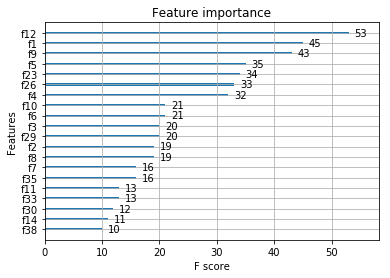

In [125]:
from xgboost import plot_importance

plt.figure(figsize=(20,8))
plot_importance(xgb, max_num_features=20)
plt.show()